In [0]:
# Load the required packages
import pandas as pd
import numpy as np
import io
import copy
import seaborn as sns
import matplotlib.pyplot as plt
from math import sqrt
from collections import deque

import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Mount the drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Load the movie titles
movie_titles = pd.read_csv('drive/My Drive/Thesis/movie_titles.csv', 
                           encoding = 'ISO-8859-1', 
                           header = None, 
                           names = ['item_id', 'year', 'name'])
movie_titles['year']=movie_titles['year'].fillna(0).astype('int32')

In [4]:
movie_titles

,item_id,year,name
0,1,2003,Dinosaur Planet
1,2,2004,Isle of Man TT 2004 Review
2,3,1997,Character
3,4,1994,Paula Abdul's Get Up & Dance
4,5,2004,The Rise and Fall of ECW
...,...,...,...
17765,17766,2002,Where the Wild Things Are and Other Maurice Se...
17766,17767,2004,Fidel Castro: American Experience
17767,17768,2000,Epoch
17768,17769,2003,The Company


In [5]:
# Path of all files
files = [
    'drive/My Drive/Thesis/combined_data_1.txt',
    'drive/My Drive/Thesis/combined_data_2.txt',
    'drive/My Drive/Thesis/combined_data_3.txt',
    'drive/My Drive/Thesis/combined_data_4.txt']

df=pd.DataFrame()
for file in files:
  # Load single data-file
  df_raw = pd.read_csv(file, header=None, names=['user_id', 'rating'], usecols=[0, 1])

  # Find empty rows to slice dataframe for each movie
  tmp_movies = df_raw[df_raw['rating'].isna()]['user_id'].reset_index()
  movie_indices = [[index, int(movie[:-1])] for index, movie in tmp_movies.values]

  # Shift the movie_indices by one to get start and endpoints of all movies
  shifted_movie_indices = deque(movie_indices)
  shifted_movie_indices.rotate(-1)

  #Gather all dataframes
  user_data = []

  # Iterate over all movies
  for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indices, shifted_movie_indices):

      # Check if it is the last movie in the file
      if df_id_1<df_id_2:
          tmp_df = df_raw.loc[df_id_1+1:df_id_2-1].copy()
      else:
          tmp_df = df_raw.loc[df_id_1+1:].copy()
          
      # Create item_id column
      tmp_df['item_id'] = movie_id 
      
      # Append dataframe to list
      user_data.append(tmp_df)

  # Combine all dataframes
  df_new = pd.concat(user_data)
  df=df.append(df_new)
  print("{0} loaded".format(file))
  print('Shape of Ratings:\t{}'.format(df.shape))

drive/My Drive/Thesis/combined_data_1.txt loaded
Shape of Ratings:	(24053764, 3)
drive/My Drive/Thesis/combined_data_2.txt loaded
Shape of Ratings:	(51031355, 3)
drive/My Drive/Thesis/combined_data_3.txt loaded
Shape of Ratings:	(73632984, 3)
drive/My Drive/Thesis/combined_data_4.txt loaded
Shape of Ratings:	(100480507, 3)


In [6]:
# Resizing the dataframe objects
df["user_id"] = pd.to_numeric(df["user_id"]).astype('int32')
df["item_id"] = df["item_id"].astype('int16')
df["rating"] = df["rating"].astype('int16')
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100480507 entries, 1 to 26851925
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int32
 1   rating   int16
 2   item_id  int16
dtypes: int16(2), int32(1)
memory usage: 1.5 GB
None


In [7]:
df

,user_id,rating,item_id
1,1488844,3,1
2,822109,5,1
3,885013,4,1
4,30878,4,1
5,823519,3,1
...,...,...,...
26851921,1790158,4,17770
26851922,1608708,3,17770
26851923,234275,1,17770
26851924,255278,4,17770


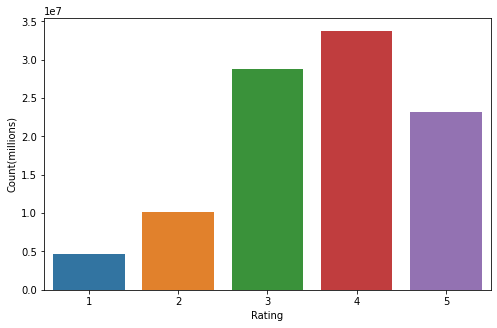

In [8]:
# Frequency of each ratings value in the complete Netﬂix Ratings dataset
fig1, ax1 = plt.subplots(figsize=(8,5))
sns.countplot(df['rating'], ax=ax1)
plt.xlabel('Rating')
plt.ylabel('Count(millions)')
plt.savefig('drive/My Drive/Thesis/Ratings.png')
plt.show()

In [0]:
# Extract top 200 users and top 500 items separately
topitems = pd.DataFrame(df['item_id'].value_counts())#.sort_index())
topitems=topitems.head(500)
topusers =pd.DataFrame(df['user_id'].value_counts())
topusers=topusers.head(200)

In [0]:
# Filter the Dataframe to keep the top users and items
df=df[df['item_id'].isin(list(topitems.index.values)) & df['user_id'].isin(list(topusers.index.values))].reset_index()
df=df.drop('index', axis=1)

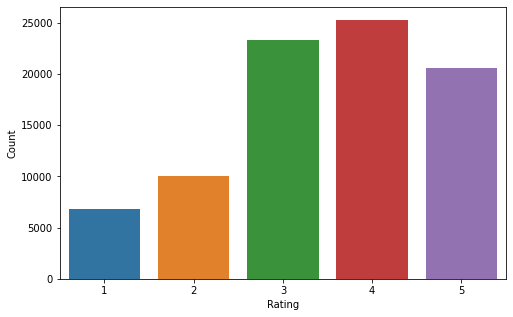

In [11]:
# Frequency of each ratings value in the pre-processed Netﬂix Ratings dataset
fig2, ax2 = plt.subplots(figsize=(8,5))
sns.countplot(df['rating'], ax=ax2)
plt.xlabel('Rating')
plt.ylabel('Count')
plt.savefig('drive/My Drive/Thesis/Ratings2.png')
plt.show()

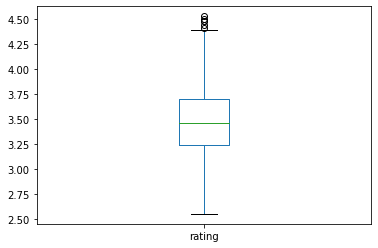

In [12]:
# Average rating per movie
df[['item_id','rating']].groupby('item_id').mean().plot(kind='box')
plt.savefig('drive/My Drive/Thesis/Average.png')
plt.show()

In [0]:
# Convert the dataframe into a sparse matrix
item_c = CategoricalDtype(sorted(df.item_id.unique()), ordered=True)
user_c = CategoricalDtype(sorted(df.user_id.unique()), ordered=True)

row = df.item_id.astype(item_c).cat.codes
col = df.user_id.astype(user_c).cat.codes
sparse_matrix = csr_matrix((df["rating"], (row, col)), \
                           shape=(item_c.categories.size, user_c.categories.size),dtype='int16')

In [14]:
# Convert the sparse matrix into a movie-user matrix
ratings=sparse_matrix.todense()
ratings=pd.DataFrame(ratings)
ratings.shape

(500, 200)

In [0]:
# Train and Test Splitting
def split(ratings):
    train_ratings, test_ratings = train_test_split(ratings.T, test_size=0.2, random_state=1440)
    train_ratings=train_ratings.reset_index().drop(['index'], 1)
    test_ratings=test_ratings.reset_index().drop(['index'], 1)
    return train_ratings,test_ratings

In [0]:
# Elbow Method for the Best K value for CLustering
def elbowmethod(train_ratings):
    train_ratings=train_ratings.T
    train_ratings['average'] = train_ratings.mean(axis=1)
    distortions=[]
    K=range(1,25) 
    for k in K:
      kmeanModel = KMeans(n_clusters=k, random_state=0,init='k-means++')
      kmeanModel.fit(train_ratings[['average']])
      distortions.append(kmeanModel.inertia_)
    plt.figure(figsize=(8,5))
    plt.plot(K, distortions, marker='o')
    plt.xlabel('K values')
    plt.ylabel('Distortion/Inertia')
    plt.savefig('drive/My Drive/Thesis/elbowoptimalK.png')
    plt.show()

In [0]:
# K-means Clustering function
def kmeans(train_ratings,test_ratings, K):
    train_ratings=train_ratings.T
    test_ratings=test_ratings.T
    train_ratings['average'] = train_ratings.mean(axis=1)
    test_ratings['average'] = test_ratings.mean(axis=1)
    kmeanModel = KMeans(n_clusters= K, random_state=0, init='k-means++')
    kmeanModel.fit(train_ratings[['average']])
    labels=kmeanModel.predict(test_ratings[['average']])
    test_ratings=test_ratings.drop(['average'], 1)
    test_clusters=copy.copy(test_ratings)
    test_clusters['Cluster']=labels
    return test_clusters,test_ratings

In [0]:
# K-medoids Clustering function
def kmedoids(train_ratings,test_ratings, K):
    train_ratings=train_ratings.T
    test_ratings=test_ratings.T
    train_ratings['average'] = train_ratings.mean(axis=1)
    test_ratings['average'] = test_ratings.mean(axis=1)
    kmedoidsModel = KMedoids(n_clusters= K, random_state=0, init='k-medoids++')
    kmedoidsModel.fit(train_ratings[['average']])
    labels=kmedoidsModel.predict(test_ratings[['average']])
    test_ratings=test_ratings.drop(['average'], 1)
    test_clusters=copy.copy(test_ratings)
    test_clusters['Cluster']=labels
    return test_clusters,test_ratings

In [0]:
# K-means Split-Merge Clustering F=function
def kmeans_split_merge(train_ratings,test_ratings,K):
    train_ratings=train_ratings.T
    test_ratings=test_ratings.T
    train_ratings['average'] = train_ratings.mean(axis=1)
    test_ratings['average'] = test_ratings.mean(axis=1)
    kmeanModel1 = KMeans(n_clusters=K, random_state=0)
    kmeanModel1.fit(train_ratings[['average']])
    centroids=kmeanModel1.cluster_centers_
    labels=kmeanModel1.labels_
    clusters=np.unique(labels)

    # Keep only centroids of clusters with data points-delete empty clusters
    new_centroids=[]
    for i in range(0,len(centroids)):
      if i in clusters:
        new_centroids=np.append(new_centroids,centroids[i])
    new_centroids=new_centroids.reshape(len(new_centroids), -1)
    
    # Get distances between cluster center and point
    X_dist = kmeanModel1.transform(train_ratings[['average']])
    df = pd.DataFrame(X_dist.min(axis=1).round(2), columns=['sqdist'])
    df['label'] = labels
    
    # Get std deviation of each cluster
    def k_std(data, cx, i_centroid):
      sum=0
      counter=0
      for i in range(0,len(data)):
        if data.iloc[i]['label']==i_centroid:
          sum=sum+(data.iloc[i]['sqdist'])**2
          counter+=1
      mean=sum/counter
      return sqrt(mean)

    total_dist = []
    for i, cx in enumerate(new_centroids):
      std_distance = k_std(df, cx[0], i)
      total_dist=np.append(total_dist,std_distance)
  
 
    # Code for splitting clusters
    outlierpresent=True
    ratings=train_ratings
    kmeanModel2 = KMeans(n_clusters=len(new_centroids), random_state=0, init=new_centroids)
    kmeanModel2.fit(ratings[['average']])
    while outlierpresent:
      for i in range(0,train_ratings.shape[0]):
        label= df.iloc[i]['label'].astype('int16')
        new=new_centroids
        if df.iloc[i]['sqdist'] > (5*total_dist[label]):
          outlier= ratings.iloc[i]['average']
          new=np.append(new,outlier)
          new=new.reshape(len(new), -1)
          kmeanModel2 = KMeans(n_clusters=len(new), random_state=0, init=new)
          kmeanModel2.fit(ratings[['average']])
          centroids=kmeanModel2.cluster_centers_
          labels=kmeanModel2.labels_
          clusters=np.unique(labels)
          
          # Keep only centroids of clusters with data points-delete empty clusters
          new_centroids=[]
          for i in range(0,len(centroids)):
            if i in clusters:
              new_centroids=np.append(new_centroids,centroids[i])
          new_centroids=new_centroids.reshape(len(new_centroids), -1)
        else:
          outlierpresent=False
    dists = euclidean_distances(new_centroids)
    
    # Code for merging clusters
    # Get distances between cluster center and point
    X_dist = kmeanModel2.transform(ratings[['average']])
    l=kmeanModel2.labels_
    df = pd.DataFrame(X_dist.min(axis=1).round(2), columns=['sqdist'])
    df['label'] = l
    
    kmeanModel3 = KMeans(n_clusters=len(new_centroids), random_state=0, init=new_centroids)
    kmeanModel3.fit(ratings[['average']])
    merged=True
    while merged:
      total_dist = []
      for i, cx in enumerate(new_centroids):
        std_distance = k_std(df, cx[0], i)
        total_dist=np.append(total_dist,std_distance)
      dists = euclidean_distances(new_centroids)
      for i in (0,len(new_centroids)-1):
          for j in range(1,len(new_centroids)):
            if dists[i][j] < (1.414*(dists[i][j]-(total_dist[i]+total_dist[j]))):
              merged=True
              new=new_centroids
              merged_centroid=(new_centroids[i]+new_centroids[j])/2      
              new =np.delete(new, [i,j])
              new=np.append(new,merged_centroid)
              new=new.reshape(len(new), -1)
              kmeanModel3 = KMeans(n_clusters=len(new), random_state=0, init=new)
              kmeanModel3.fit(ratings[['average']])
              X_dist = kmeanModel3.transform(ratings[['average']])
              l=kmeanModel3.labels_
              df = pd.DataFrame(X_dist.min(axis=1).round(2), columns=['sqdist'])
              df['label'] = l
              new_centroids=kmeanModel3.cluster_centers_
              break
            else:
              merged=False
          break 
    print("Initial Number of Clusters of K-means Split-Merge:{0}".format(K))
    print("Final Number of Clusters of K-means Split-Merge:{0}".format(len(kmeanModel3.cluster_centers_)))
    final_clus=len(kmeanModel3.cluster_centers_)
    labels=kmeanModel3.predict(test_ratings[['average']]) 
    test_ratings=test_ratings.drop(['average'], 1)
    test_clusters=copy.copy(test_ratings)
    test_clusters['Cluster']=labels
    return test_clusters,test_ratings,final_clus

In [0]:
# Applying the KNN algorithm to get the nearest neighbors
def predict_itembased(user_id, item_id, ratings, model, col, k):
    prediction= 0
    wtd_sum =0
    similarities=[]
    similarities=np.array(similarities)
    indices=[]  
    new_distances=[]
    new_distances=np.array(new_distances)
    new_indices=[]
    distances, indices = model.kneighbors(ratings.iloc[item_id-1, :].values.reshape(1, -1), n_neighbors = ratings.shape[0])
    for i in range(0,len(indices[0])):
      if len(new_indices) < k :
        if indices[0][i] in col:
          new_indices.append(indices[0][i])
          new_distances=np.append(new_distances,distances[0][i])
      else :
        break
    similarities = 1-new_distances
    sum_wt = np.sum(similarities)-1
    product=1
    ratings=ratings.T
    for i in range(0, len(new_indices)):
        if new_indices[i]+1 == item_id:
            continue;
        else:
            product = ratings.iloc[user_id-1,new_indices[i]] * (similarities[i])
            wtd_sum = wtd_sum + product                              
    if sum_wt == 0:
      prediction=0
    else: 
      prediction = int(round(wtd_sum/sum_wt))  
    return prediction

In [0]:
# Prediction and Evaluation of the Recommender system
def evaluateRS(test_clusters,test_ratings,KNN=5):
    n_users_test = test_ratings.shape[1]
    n_items_test = test_ratings.shape[0]
    scale=5
    model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
    model_knn.fit(test_ratings)
    prediction = np.zeros((n_users_test, n_items_test))
    prediction= pd.DataFrame(prediction)
    for i in range(n_users_test):
      for j in range(n_items_test):
        cluster=test_clusters.at[j,'Cluster']  
        new = test_clusters.index[test_clusters.Cluster == cluster]
        col=new.values.tolist()
        prediction[i][j] = predict_itembased(i+1, j+1, test_ratings, model_knn, col,KNN)
      #print("user {0} is done".format(i+1))
    MSE = mean_squared_error(prediction, test_ratings.T)
    MAE= round(mean_absolute_error(prediction, test_ratings.T)/scale,5)
    RMSE = round(sqrt(MSE)/scale,5)
    print("RMSE:",RMSE)
    print("MAE:",MAE)
    return RMSE, MAE

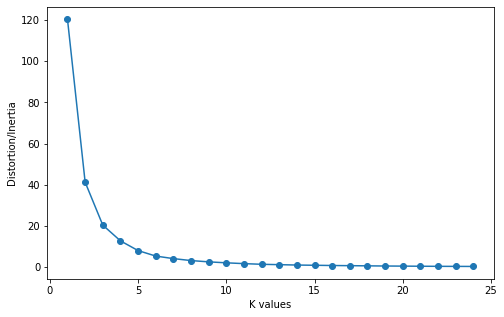

In [22]:
# Splitting the user-item matrix into the train and test
train, test = split(ratings)

# Elbow method to find the minimum optimal K value for K-means Clustering
elbowmethod(train)

In [0]:
#Specify the values of K for Clustering
K_values=[2,3,5,10,15,25,50,75,100]

In [24]:
# Executing the Split-Merge K-means for KNN with 5 nearest neighbors
all_final_clus_count=[]
all_rmse_splitmergekmeans=[]
all_mae_splitmergekmeans=[]
for K in K_values:
  clusters_splitmergekmeans, test_splitmergekmeans, final_clus_count = kmeans_split_merge(train, test, K)
  print("The RMSE and MAE for K-Means Split-Merge based CF-I with K={0}:".format(K))
  rmse_splitmergekmeans, mae_splitmergekmeans= evaluateRS(clusters_splitmergekmeans, test_splitmergekmeans)

  all_final_clus_count.append(final_clus_count)
  all_rmse_splitmergekmeans.append(rmse_splitmergekmeans)
  all_mae_splitmergekmeans.append(mae_splitmergekmeans)

print(all_final_clus_count)
print(all_rmse_splitmergekmeans)
print(all_mae_splitmergekmeans)


Initial Number of Clusters of K-means Split-Merge:2
Final Number of Clusters of K-means Split-Merge:2
The RMSE and MAE for K-Means Split-Merge based CF-I with K=2:
RMSE: 0.6561
MAE: 0.56922
Initial Number of Clusters of K-means Split-Merge:3
Final Number of Clusters of K-means Split-Merge:3
The RMSE and MAE for K-Means Split-Merge based CF-I with K=3:
RMSE: 0.65574
MAE: 0.56884
Initial Number of Clusters of K-means Split-Merge:5
Final Number of Clusters of K-means Split-Merge:5
The RMSE and MAE for K-Means Split-Merge based CF-I with K=5:
RMSE: 0.65578
MAE: 0.56899
Initial Number of Clusters of K-means Split-Merge:10
Final Number of Clusters of K-means Split-Merge:3
The RMSE and MAE for K-Means Split-Merge based CF-I with K=10:
RMSE: 0.65575
MAE: 0.5688
Initial Number of Clusters of K-means Split-Merge:15
Final Number of Clusters of K-means Split-Merge:3
The RMSE and MAE for K-Means Split-Merge based CF-I with K=15:
RMSE: 0.65575
MAE: 0.5688
Initial Number of Clusters of K-means Split-

The mean MAE of K-Means Split-Merge based  CF-I: 0.5690022222222223
The Std Dev of K-Means Split-Merge based  CF-I: 0.00020065325413523143


<function matplotlib.pyplot.show>

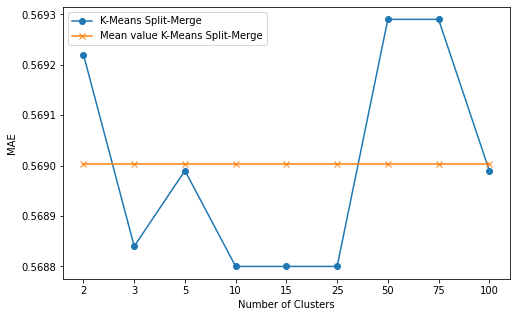

In [32]:
print("The mean MAE of K-Means Split-Merge based  CF-I: {0}".format(np.mean(all_mae_splitmergekmeans)))
print("The Std Dev of K-Means Split-Merge based  CF-I: {0}".format(np.std(all_mae_splitmergekmeans)))

fig4, ax4 = plt.subplots(figsize=(8,5))
my_ticks = [i for i in range(len(K_values))]
ax4.set_xticks(my_ticks)
ax4.set_xticklabels(K_values)
ax4.plot(my_ticks, all_mae_splitmergekmeans, label = "K-Means Split-Merge", marker='o')
ax4.plot(my_ticks, [np.mean(all_mae_splitmergekmeans)]*len(my_ticks), label = "Mean value K-Means Split-Merge", marker='x')
plt.xlabel('Number of Clusters')
plt.ylabel('MAE')
plt.title('')
plt.legend()
plt.savefig('drive/My Drive/Thesis/Mean.png')
plt.show

In [26]:
# Executing the K-means for KNN with 5 nearest neighbors 
all_rmse_kmeans=[]
all_mae_kmeans=[]
for K in K_values:
  clusters_kmeans, test_kmeans=kmeans(train, test, K)
  print("The RMSE and MAE for K-Means based CF-I with K={0}:".format(K))
  rmse_kmeans, mae_kmeans = evaluateRS(clusters_kmeans, test_kmeans)

  all_rmse_kmeans.append(rmse_kmeans)
  all_mae_kmeans.append(mae_kmeans)

print(all_rmse_kmeans)
print(all_mae_kmeans)

The RMSE and MAE for K-Means based CF-I with K=2:
RMSE: 0.6561
MAE: 0.56922
The RMSE and MAE for K-Means based CF-I with K=3:
RMSE: 0.65574
MAE: 0.56884
The RMSE and MAE for K-Means based CF-I with K=5:
RMSE: 0.65578
MAE: 0.56899
The RMSE and MAE for K-Means based CF-I with K=10:
RMSE: 0.65571
MAE: 0.56914
The RMSE and MAE for K-Means based CF-I with K=15:
RMSE: 0.65576
MAE: 0.56933
The RMSE and MAE for K-Means based CF-I with K=25:
RMSE: 0.65576
MAE: 0.56941
The RMSE and MAE for K-Means based CF-I with K=50:
RMSE: 0.65575
MAE: 0.56933
The RMSE and MAE for K-Means based CF-I with K=75:
RMSE: 0.65577
MAE: 0.56938
The RMSE and MAE for K-Means based CF-I with K=100:
RMSE: 0.65582
MAE: 0.56939
[0.6561, 0.65574, 0.65578, 0.65571, 0.65576, 0.65576, 0.65575, 0.65577, 0.65582]
[0.56922, 0.56884, 0.56899, 0.56914, 0.56933, 0.56941, 0.56933, 0.56938, 0.56939]


In [27]:
# Executing the K-medoids for KNN with 5 nearest neighbors
all_rmse_kmedoids=[]
all_mae_kmedoids=[]
for K in K_values:
  clusters_kmedoids, test_kmedoids = kmedoids(train, test, K)
  print("The RMSE and MAE for K-Medoids based CF-I with K={0}:".format(K))
  rmse_kmedoids, mae_kmedoids = evaluateRS(clusters_kmedoids, test_kmedoids)

  all_rmse_kmedoids.append(rmse_kmedoids)
  all_mae_kmedoids.append(mae_kmedoids)

print(all_rmse_kmedoids)
print(all_mae_kmedoids)

The RMSE and MAE for K-Medoids based CF-I with K=2:
RMSE: 0.6561
MAE: 0.56922
The RMSE and MAE for K-Medoids based CF-I with K=3:
RMSE: 0.65575
MAE: 0.56878
The RMSE and MAE for K-Medoids based CF-I with K=5:
RMSE: 0.65574
MAE: 0.56894
The RMSE and MAE for K-Medoids based CF-I with K=10:
RMSE: 0.65583
MAE: 0.56935
The RMSE and MAE for K-Medoids based CF-I with K=15:
RMSE: 0.65566
MAE: 0.56913
The RMSE and MAE for K-Medoids based CF-I with K=25:
RMSE: 0.65577
MAE: 0.56945
The RMSE and MAE for K-Medoids based CF-I with K=50:
RMSE: 0.65556
MAE: 0.56886
The RMSE and MAE for K-Medoids based CF-I with K=75:
RMSE: 0.65592
MAE: 0.56949
The RMSE and MAE for K-Medoids based CF-I with K=100:
RMSE: 0.65579
MAE: 0.56934
[0.6561, 0.65575, 0.65574, 0.65583, 0.65566, 0.65577, 0.65556, 0.65592, 0.65579]
[0.56922, 0.56878, 0.56894, 0.56935, 0.56913, 0.56945, 0.56886, 0.56949, 0.56934]


<function matplotlib.pyplot.show>

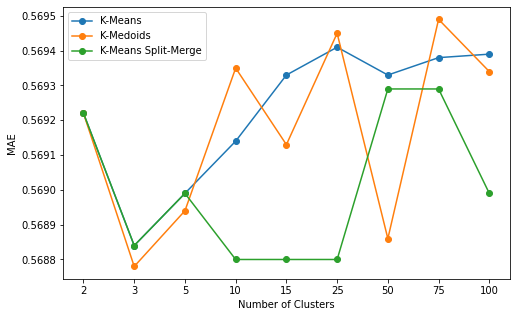

In [28]:
# Plot the MAE for all values of K for all clustering based collaborative filtering
fig5, ax5 = plt.subplots(figsize=(8,5))
my_ticks = [i for i in range(len(K_values))]
ax5.set_xticks(my_ticks)
ax5.set_xticklabels(K_values)
ax5.plot(my_ticks, all_mae_kmeans, label = "K-Means", marker='o')
ax5.plot(my_ticks, all_mae_kmedoids, label = "K-Medoids", marker='o')
ax5.plot(my_ticks, all_mae_splitmergekmeans, label = "K-Means Split-Merge", marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('MAE')
plt.title('')
plt.legend()
plt.savefig('drive/My Drive/Thesis/MAE_for_5NN.png')
plt.show

<function matplotlib.pyplot.show>

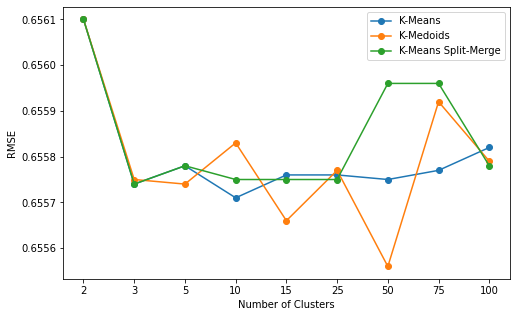

In [29]:
# Plot the RMSE for all values of K for all clustering based collaborative filtering
fig6, ax6 = plt.subplots(figsize=(8,5))
my_ticks = [i for i in range(len(K_values))]
ax6.set_xticks(my_ticks)
ax6.set_xticklabels(K_values)
ax6.plot(my_ticks, all_rmse_kmeans, label = "K-Means", marker='o')
ax6.plot(my_ticks, all_rmse_kmedoids, label = "K-Medoids", marker='o')
ax6.plot(my_ticks, all_rmse_splitmergekmeans, label = "K-Means Split-Merge", marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('RMSE')
plt.title('')
plt.legend()
plt.savefig('drive/My Drive/Thesis/RMSE_for_5NN.png')
plt.show

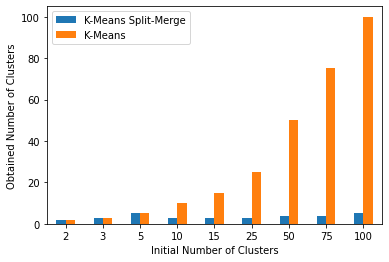

In [30]:
pd.DataFrame(np.c_[all_final_clus_count, K_values], index=K_values).plot.bar(rot=0)
plt.legend(('K-Means Split-Merge', 'K-Means'))
plt.xlabel('Initial Number of Clusters')
plt.ylabel('Obtained Number of Clusters')
plt.savefig('drive/My Drive/Thesis/Initial_Final_K.png')
plt.show()

RMSE: 0.65512
MAE: 0.56854
RMSE: 0.65455
MAE: 0.56772
RMSE: 0.65534
MAE: 0.56851
RMSE: 0.65474
MAE: 0.56793
Initial Number of Clusters of K-means Split-Merge:10
Final Number of Clusters of K-means Split-Merge:3
RMSE: 0.6551
MAE: 0.56818
RMSE: 0.65485
MAE: 0.5678
[0.56914, 0.56854, 0.56772]
[0.56935, 0.56851, 0.56793]
[0.5688, 0.56818, 0.5678]


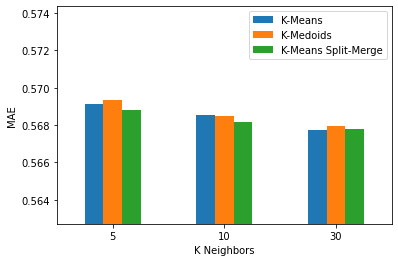

In [31]:
kmeans_mae_KNNvalues=[]
kmedoids_mae_KNNvalues=[]
splitmergekmeans_mae_KNNvalues=[]

kmeans_mae_KNNvalues.append(all_mae_kmeans[3])
kmedoids_mae_KNNvalues.append(all_mae_kmedoids[3])
splitmergekmeans_mae_KNNvalues.append(all_mae_splitmergekmeans[3])

clusters_kmeans, test_kmeans=kmeans(train, test, 10)
rmse_kmeans, mae_kmeans = evaluateRS(clusters_kmeans, test_kmeans, 10)
kmeans_mae_KNNvalues.append(mae_kmeans)
rmse_kmeans, mae_kmeans = evaluateRS(clusters_kmeans, test_kmeans, 30)
kmeans_mae_KNNvalues.append(mae_kmeans)

clusters_kmedoids, test_kmedoids = kmedoids(train, test, 5)
rmse_kmedoids, mae_kmedoids = evaluateRS(clusters_kmedoids, test_kmedoids, 10)
kmedoids_mae_KNNvalues.append(mae_kmedoids)
rmse_kmedoids, mae_kmedoids = evaluateRS(clusters_kmedoids, test_kmedoids, 30)
kmedoids_mae_KNNvalues.append(mae_kmedoids)

clusters_splitmergekmeans, test_splitmergekmeans, final_clus_count = kmeans_split_merge(train, test, 10)
rmse_splitmergekmeans, mae_splitmergekmeans= evaluateRS(clusters_splitmergekmeans, test_splitmergekmeans, 10)
splitmergekmeans_mae_KNNvalues.append(mae_splitmergekmeans)
rmse_splitmergekmeans, mae_splitmergekmeans= evaluateRS(clusters_splitmergekmeans, test_splitmergekmeans, 30)
splitmergekmeans_mae_KNNvalues.append(mae_splitmergekmeans)


print(kmeans_mae_KNNvalues)
print(kmedoids_mae_KNNvalues)
print(splitmergekmeans_mae_KNNvalues)

new_plot_df=pd.DataFrame(np.c_[kmeans_mae_KNNvalues,kmedoids_mae_KNNvalues,splitmergekmeans_mae_KNNvalues], index=[5,10,30])
new_plot_df.plot.bar(rot=0)
max_val=new_plot_df.values.max()
min_val=new_plot_df.values.min()
plt.ylim(min_val-0.005, max_val+0.005)
plt.legend(('K-Means','K-Medoids','K-Means Split-Merge'))
plt.xlabel('K Neighbors')
plt.ylabel('MAE')
plt.savefig('drive/My Drive/Thesis/differentK_mae.png')
plt.show()